# Supply Chain Network Graphs

_Forget about your competitors, just focus on your customers_ - Jack Ma

Supply chain networks comprise the interconnected relationships between suppliers and their customers. An effective way to study these relationships is by constructing graphs that visually and mathematically represent supply chain structures. We introduce key properties of graphical networks, such as degree distribution, clustering coefficients, and path lengths, and explore how to identify central and connected firms.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import math
import numpy as np
import pandas as pd
import networkx as nx
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.database import SQL
from finds.recipes import graph_draw
from secret import credentials
import warnings
# %matplotlib qt
VERBOSE = 0
if not VERBOSE:
    warnings.simplefilter(action='ignore', category=FutureWarning)
sql = SQL(**credentials['sql'], verbose=VERBOSE)

## Principal customers

The relationships between upstream suppliers and downstream customers, collectively known as "supply chain" relationships, form a crucial component of economic linkages, representing the movement of goods, services, and financial transactions across industries and individual firms.

**Principal customers** are those that contribute more than 10% of a firm's total sales, as defined by Regulation S-K and SFAS 131. Under these disclosure requirements, suppliers are often significantly smaller than their corporate principal customers.

Retrieve principal customer relationships from the database:

In [2]:
# retrieve principal customers info
year = 2022
cust = sql.read_dataframe(f"select gvkey, cgvkey, stic, ctic, conm, cconm "
                          f"  from customer "
                          f"    where srcdate >= {year}0101 "
                          f"      and srcdate <= {year}1231")

Construct a lookup table to map company tickers to their full names:

In [3]:
# construct Series to lookup company full name from ticker
lookup = pd.concat([Series(cust['conm'].values, cust['stic'].values),
                    Series(cust['cconm'].values, cust['ctic'].values)])\
           .drop_duplicates()

## Graph properties


In a __graph__, __nodes__ (also called vertices) represent entities, while __edges__ denote relationships between them. The __degree__ of a node is the number of edges directly connected to it.

__Density__ measures the proportion of existing edges relative to the maximum possible edges:
- In undirected graphs: $\frac{2m}{n(n-1)}$
- In directed graphs: $\frac{m}{n(n-1)}$

where $m$ is the number of edges and $n$ is the number of nodes.

A __simple graph__ has no self-loops (edges connecting a node to itself) and does not contain multiple edges between the same pair of nodes.

A __subgraph__ is a subset of nodes and the edges that connect them. A __component__ is a subgraph in which every node is connected to every other node by some path.

Key graph attributes include:
- **Weighted vs. Unweighted:** Indicates whether numerical values are assigned to edges.
- **Directed vs. Undirected:** Determines whether edges have a defined direction.
- **Cyclic vs. Acyclic:** A cyclic graph contains at least one cycle (a path that starts and ends at the same node), while an acyclic graph does not.
- **Connected vs. Disconnected:** A graph is connected if a path exists between any two nodes.
- **Weakly vs. Strongly Connected Components:** Weakly connected components have a path between every pair of nodes when edge direction is ignored, whereas strongly connected components require directed paths between every pair of nodes.


To model supply chains, we construct a directed graph with edges pointing from suppliers to their principal customers and analyze its structural properties.

In [4]:
# nodes are companies, with directed edges from supplier to customer
vertices = set(cust['stic']).union(cust['ctic'])
edges = cust[['stic', 'ctic']].values.tolist()  # supplier --> customer

In [5]:
# Populate networkx directed graph with nodes and edges
DG = nx.DiGraph()
DG.add_nodes_from(vertices)
DG.add_edges_from(edges)

Display graph properties:

In [6]:
# Helper to display graph properties
def graph_info(G):
    out = dict()
    out['is_directed'] = nx.is_directed(G)
    out['num_edges'] = nx.number_of_edges(G)
    out['num_nodes'] = nx.number_of_nodes(G)
    out['num_selfloops'] = nx.number_of_selfloops(G)
    out['density'] = nx.density(G)

    out['is_weighted'] = nx.is_weighted(G)
    if nx.is_weighted(G):
        out['is_negatively_weighted'] = nx.is_negatively_weighted(G)
    
    # Components
    if nx.is_directed(G):
        out['is_weakly_connected'] = nx.is_weakly_connected(G)
        out['weakly_connected_components'] = nx.number_weakly_connected_components(G)
        out['size_largest_weak_component'] = len(max(
            nx.weakly_connected_components(G), key=len))
        out['is_strongly_connected'] = nx.is_strongly_connected(G)
        out['strongly_connected_components'] = nx.number_strongly_connected_components(G)
        out['size_largest_strong_component'] = len(max(
            nx.strongly_connected_components(G), key=len))
    else:
        out['is_connected'] = nx.is_connected(G)
        out['connected_components'] = nx.number_connected_components(G)
        out['size_largest_component'] = len(max(
            nx.connected_components(G), key=len))
    return out

In [7]:
Series(graph_info(DG)).rename('Principal Customers Graph').to_frame()

,Principal Customers Graph
is_directed,True
num_edges,2561
num_nodes,1696
num_selfloops,5
density,0.000891
is_weighted,False
is_weakly_connected,False
weakly_connected_components,111
size_largest_weak_component,1398
is_strongly_connected,False


In [8]:
# remove self-loops, if any
DG.remove_edges_from(nx.selfloop_edges(DG))

### Clustering coefficient

The clustering coefficient measures how nodes in a graph tend to cluster together.

- A **triplet** consists of three nodes connected by two (open triplet) or three (closed triplet) edges.
- A **triangle** comprises three closed triplets.
- The **clustering coefficient** of a node is given by:

  $$\frac{2 \times \text{\# of triangles}}{\text{degree} \times (\text{degree} - 1)}$$

- **Graph transitivity** is the fraction of all possible triangles that are actually present:
  $$3 \times \frac{\text{\# of triangles}}{\text{\# of triads}}$$

In [9]:
# as an undirected graph
G = nx.Graph(DG)
DataFrame({'transitivity': nx.transitivity(G),
           'average clustering': nx.average_clustering(G)},
          index=['clustering'])

,transitivity,average clustering
clustering,0.007702,0.011649


### Degree analysis


In directed graphs:
- **Out-degree** represents the number of edges pointing out from a node.
- **In-degree** represents the number of edges pointing into a node.


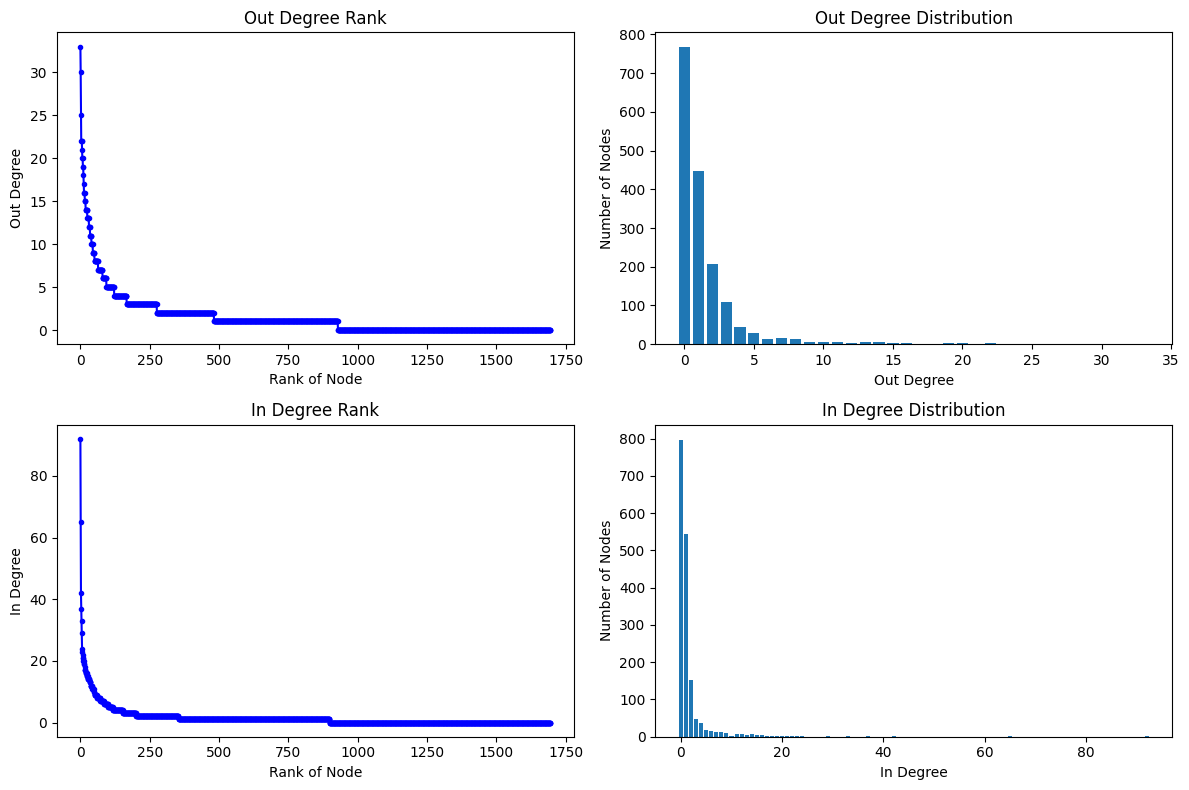

In [10]:
# Plot distribution of degrees
degrees = {'Out Degree': sorted((d for n, d in DG.out_degree()), reverse=True),
           'In Degree': sorted((d for n, d in DG.in_degree()), reverse=True)}
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for ax, direction in zip(axes, degrees):
    ax[0].plot(degrees[direction], "b-", marker=".")
    ax[0].set_title(f"{direction} Rank")
    ax[0].set_ylabel(f"{direction}")
    ax[0].set_xlabel("Rank of Node")
    ax[1].bar(*np.unique(degrees[direction], return_counts=True))
    ax[1].set_title(f"{direction} Distribution")
    ax[1].set_xlabel(f"{direction}")
    ax[1].set_ylabel("Number of Nodes")
plt.tight_layout()
plt.show()

### Ego network

An __ego__ is a focal node in a network. Each node in a network can serve as an ego. A __neighborhood__ consists of the ego and all nodes directly connected to it.

For analysis, we select the node with the highest degree as the focal node and construct its one-step neighborhood, capturing immediate suppliers and principal customers.


In [11]:
# find node with greatest degree
(ego, degree) = max(G.degree(), key=lambda x: x[1])

# build subgraph of ego and neighbors
all_neighbors = list(nx.all_neighbors(DG, ego))  # predecessors and successors
neighbors = list(nx.neighbors(DG, ego))          # successors only
ego_graph = DG.subgraph([ego] + all_neighbors).copy()

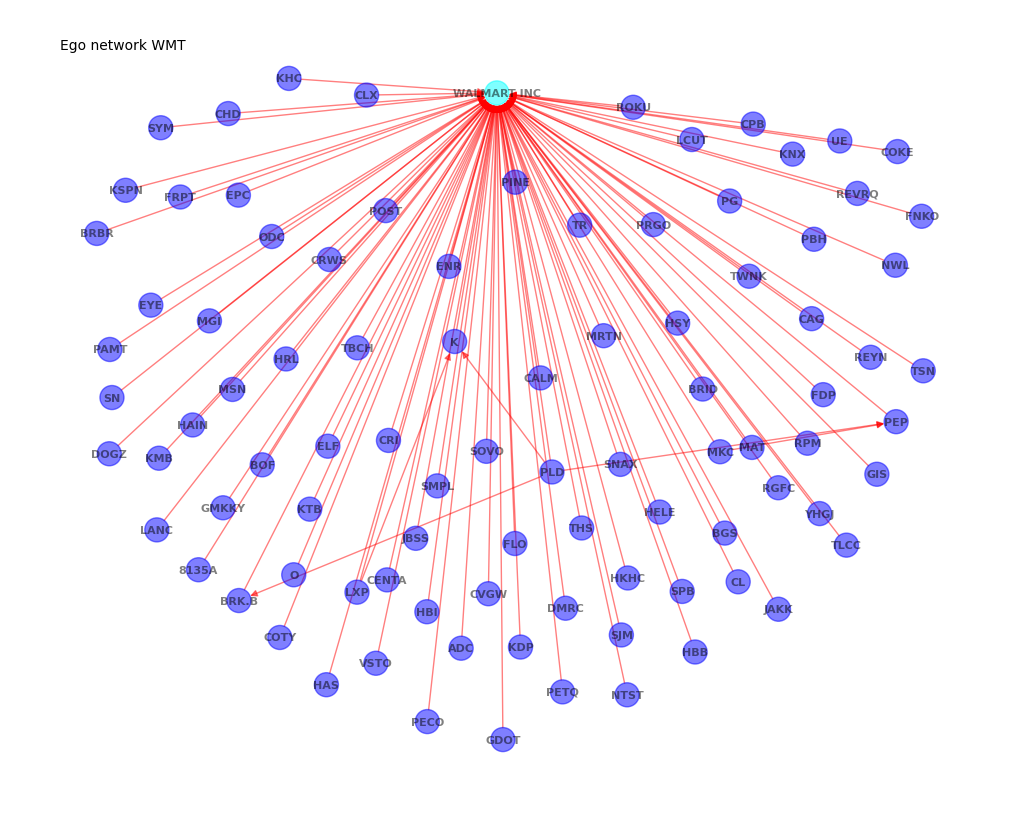

In [13]:
# Plot ego graph
node_color = (dict.fromkeys(all_neighbors, 'b')   # plot predecessor (supplier) nodes in blue
              | dict.fromkeys(neighbors, 'g')     # plot successor (customer) nodes in green
              | {ego: 'cyan'})

labels = ({ticker: ticker for ticker in ego_graph.nodes}
          | {ticker: lookup[ticker] for ticker in [ego] + neighbors})

graph_draw(ego_graph, figsize=(10, 8), node_size=300, seed=42, 
           width=1, node_color=node_color, labels=labels, style='-',
           title=f"Ego network {ego}") 
plt.show()

### Path lengths

The __distance__ or __path length__ between two nodes is the shortest path (fewest number of edges) between them.

- **Eccentricity** of a node is the maximum distance from that node to any other node in the graph.
- **Diameter** is the maximum eccentricity across all nodes in the graph.

To analyze path lengths, we identify the largest connected component of the graph and compute the longest undirected path within it.

In [14]:
# find component with the longest diameter
components = list(nx.weakly_connected_components(DG))
nodes = components[np.argmax([nx.diameter(G.subgraph(c)) for c in components])]

In [15]:
# compute all shortest path lengths, and determine the longest
best_length = 0
for src, targets in dict(nx.shortest_path(G.subgraph(nodes))).items():
    for tgt, path in targets.items():
        length = len(path)
        if length > best_length:
            best_length = length
            best_path = path

{'CGAU': (5.0, 0.0),
 'RGLD': (3.2418138352088386, 5.048825908847379),
 'TECK': (-2.9130278558299967, 6.365081987779772),
 'HL': (-7.919939972803563, 1.1289600644789377),
 'CM': (-5.882792587772507, -6.811222457771354),
 'SSRM': (2.8366218546322624, -9.589242746631385),
 'BMO': (10.561873153154025, -3.0735704801881845),
 'CDE': (9.046827052119655, 7.883839184625469),
 'TD': (-1.8915004395119759, 12.861657206103963),
 'SLG': (-12.755823666385478, 5.769658793384592),
 'SONY': (-12.586072936146786, -8.160316663340547),
 'SYNA': (0.07081116780881257, -15.999843304811256),
 'F': (14.345517298452366, -9.121739606007393),
 'VC': (16.33404206610353, 7.563006662879537),
 'MBGYY': (2.5980071459488383, 18.821539758202537),
 'NPO': (-15.193758257176427, 13.005756803142337),
 'CVX': (-20.110849086791077, -6.045969649966372),
 'MUR': (-6.053593437135133, -21.15074482135025),
 'PSX': (15.187284289613844, -17.272706675748548),
 'SPND': (23.72891083648006, 3.597053031910856),
 'DCP': (10.20205154533479

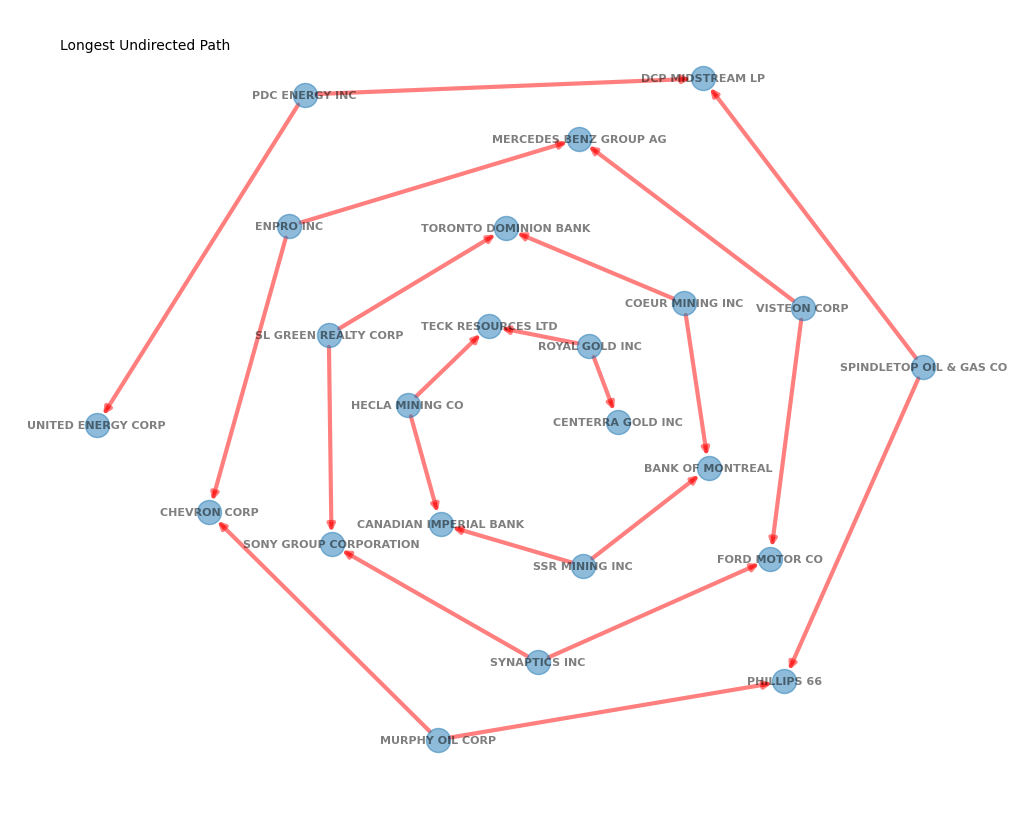

In [16]:
# Archimedean spiral: r = b theta
pos = {ticker: ((n + 5) * math.cos(n), (n + 5) * math.sin(n))
       for n, ticker in enumerate(best_path)}

# Plot nodes in a spiral graph
labels = {ticker: lookup[ticker] for ticker in best_path}
graph_draw(DG.subgraph(best_path), figsize=(10, 8), node_size=300,
           width=3, labels=labels, style='-',  pos=pos,
           title=f"Longest Undirected Path") 

**References:**

Ling Cen and Sudipto Dasgupta, 2021, The Economics and Finance of Customer-Supplier Relationships, Oxford Research Encyclopedia of Economics and Finance.

Cen, Ling, et al. "Customer–supplier relationships and corporate tax avoidance." Journal of Financial Economics 123.2 (2017): 377-394.

Cohen, Lauren, and Andrea Frazzini. "Economic links and predictable returns." The Journal of Finance 63.4 (2008): 1977-2011.

Wharton Research Data Services.